# Projections

Web mapping tools using tiles use a variant of the Mercator Projection.
- [OpenStreetMap Wiki](http://wiki.openstreetmap.org/wiki/Slippy_map_tilenames)
- [Mercator projection](https://en.wikipedia.org/wiki/Mercator_projection)
- [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator)

This can lead to some significant distortions: you can see this for yourself by zooming out in google maps, and scrolling around.  The scale (bottom right) will change, depending on where you are on the globe.  Locally, the distortion is not too bad, but tiles from different areas of the globe cannot be directly compared.

Internally, the projection maps the whole globe (between latitudes about -85 to 85 degrees) to a unit square:

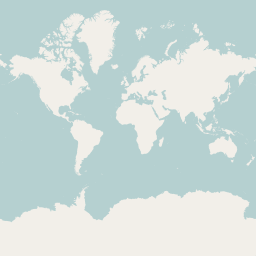

In [1]:
import tilemapbase
tilemapbase.start_logging()
tilemapbase.tiles.build_OSM().get_tile(0,0,0)

## Comparison to standards

The standards [EPSG:3857](http://spatialreference.org/ref/sr-org/6864/) or [EPSG:3785](http://spatialreference.org/ref/epsg/popular-visualisation-crs-mercator/) are mentioned in relation to the "web mercator" projection.

The following (reproduced in `tilemapbase`) shows that the projections are the same, up to a rescaling, and flipping the y axis.

(It is curious to compare the text in the above two links, which to a causual reader might warn against using 3857 while 3785 is fine; they are both identical...)

In [2]:
import pyproj
p3857 = pyproj.Proj({"init": "epsg:3857"})
p3785 = pyproj.Proj({"init": "epsg:3785"})

In [3]:
scale = 20037508.342789244

def rescale(x, y):
    return ((x - 0.5) * 2 * scale, (0.5 - y) * 2 * scale)

import random, math

diffs = []
for _ in range(10000):
    x = random.random() * 360 - 180
    y = random.random() * 170 - 85

    assert p3857(x, y) == p3785(x, y)
    xx, yy = p3857(x, y)
    xxx, yyy = rescale(*tilemapbase.project(x, y))
    diffs.append( math.sqrt((xx - xxx)**2 + (yy - yyy)**2) )

In [4]:
max(diffs), sum(diffs) / 10000

(3.129243850708008e-07, 4.728993730872364e-09)

# UK National Grid

To support the Ordance Survey (raster) tiles, we need to use the [Ordnance Survey National Grid](https://en.wikipedia.org/wiki/Ordnance_Survey_National_Grid).

- This is [EPSG:7405](http://www.spatialreference.org/ref/epsg/osgb36-british-national-grid-odn-height/)
- We need to be careful, as the British National Grid uses a different ellipsoid (approximation to the shape of the Earth) than the "usual" GPS based on.
- So we need to use the `transform` method of `pyproj`.  [Credit](https://osedok.wordpress.com/2012/01/17/conversion-of-british-national-grid-wkid27700-to-wgs84wkid4326-and-then-to-webmercator-wkid102100/)


For example:
- Corner of the Garstang Building at the university of Leeds has Lon/Lat coords -1.55532, 53.80474
- See [OS Maps Online](https://osmaps.ordnancesurvey.co.uk/53.80474,-1.55532,17/pin)
- Claims to be SE 29383 34363
- [Land's end](https://osmaps.ordnancesurvey.co.uk/50.06942,-5.71808,17/pin)  -5.71808, 50.06942
- Is SW 34041 25435
- [John O'Groats](https://osmaps.ordnancesurvey.co.uk/58.64389,-3.02516,17/pin) -3.02516, 58.64389
- Is ND 40594 73345


Further information: https://www.ordnancesurvey.co.uk/business-and-government/help-and-support/navigation-technology/os-net/formats-for-developers.html

In [5]:
import pyproj, functools

bng = pyproj.Proj(init="epsg:27700")
wgs84 = pyproj.Proj(init="epsg:4326")

def project(lon, lat):
    return pyproj.transform(wgs84, bng, lon, lat)

print(project(-1.55532, 53.80474))
print(project(-5.71808, 50.06942))
print(project(-3.02516, 58.64389))

(429383.15535284596, 434363.0962840691)
(134041.0757940985, 25435.90742218544)
(340594.4899132418, 973345.1181793772)
